<a href="https://colab.research.google.com/github/ekaterinatao/NER_biomed_domain/blob/main/active_learning/%D0%92%D0%9A%D0%A0_nerel_bio_RuBioBERT_active_learning_v6_bald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инструменты
Предобработанный дасасет [NEREL-BIO](https://huggingface.co/datasets/ekaterinatao/nerel_bio_ner_unnested)  

Исходная модель [RuBioBERT](https://huggingface.co/alexyalunin/RuBioBERT)

### Установка зависимостей

In [1]:
!pip install datasets accelerate evaluate wandb seqeval -q
!pip install baal -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.0

In [2]:
import numpy as np
import pandas as pd
import random
from dataclasses import dataclass
import torch
from torch.nn.functional import softmax
import datasets
from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import (AutoTokenizer,
                          DataCollatorForTokenClassification,
                          AutoModelForTokenClassification,
                          TrainingArguments, Trainer,
                          pipeline)
from transformers.trainer_utils import get_last_checkpoint
import evaluate

import warnings
warnings.filterwarnings("ignore")

In [15]:
@dataclass
class TrainingConfig:
    seed = 64
    dataset = 'ekaterinatao/nerel_bio_ner_unnested'
    checkpoint = 'alexyalunin/RuBioBERT'
    hf_repo_id = "ekaterinatao/nerel-bio-RuBioBERT-al"
    n_labels = 45
    n_epochs = 10
    train_batch_size = 4
    eval_batch_size = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    l_rate = 5e-05
    w_decay = 0.1
    warm_up = 0.1
    run_name="RuBioBERT_AL_v6_1"

config = TrainingConfig()

In [4]:
seed = config.seed

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Скачивание датасета

In [5]:
dataset = datasets.load_dataset(config.dataset)
dataset

Generating train split:   0%|          | 0/612 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/77 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/77 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 612
    })
    valid: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 77
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 77
    })
})

In [6]:
# Labels
url = 'https://raw.githubusercontent.com/ekaterinatao/NER_biomed_domain/main/labels.txt'
tags = pd.read_csv(url, names=['tag']).values.tolist()
tags = [item for sublist in tags for item in sublist]
tag_to_id = {tag: i for i, tag in enumerate(tags)}
id_to_tag = {i: tag for i, tag in enumerate(tags)}

___
### Токенизация

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config.checkpoint)

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["words"], truncation=True, max_length=512, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_idxs = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_idxs:
            if word_idx is None:
                label_ids.append(-100) # Set the special tokens to -100.
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [9]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels, batched=True,
    #remove_columns = ['id', 'words', 'ner_tags']
)
tokenized_dataset

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 612
    })
    valid: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 77
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 77
    })
})

# Обучение модели

In [10]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [11]:
def choose_samples_bald(test_predictions, n_tokens) -> np.ndarray:
    """Функция для реализации стратеги отбора примеров для разметки
    на основе BALD
    https://github.com/baal-org/baal/tree/master"""

    from baal.active.heuristics import BALD

    # test_preds_new (DATASET_LEN, NUM_CLASSES, NUM_TOKENS)
    test_preds_new = np.transpose(test_predictions, (0, 2, 1))
    bald = BALD()
    scores = bald.get_uncertainties(test_preds_new)
    args = np.argsort(-scores)

    return args[:n_tokens]

In [12]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [13]:
model = AutoModelForTokenClassification.from_pretrained(
    config.checkpoint, num_labels=config.n_labels, id2label=id_to_tag, label2id=tag_to_id
)

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print(f'device is {config.device}')

device is cuda


In [16]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
import wandb
wandb.login()

wandb: Currently logged in as: taoea. Use `wandb login --relogin` to force relogin


True

In [20]:
import os
os.environ["WANDB_PROJECT"]="ner_bert_nerel_bio"

In [21]:
def train_and_predict(
    al_train_dataset, eval_dataset, al_test_dataset, test_dataset,
    model, tokenizer, data_collator, compute_metrics
):
    "Функция для тренировки модели, сохранения метрик и предсказаний"

    global config
    training_args = TrainingArguments(
        output_dir=config.hf_repo_id,
        num_train_epochs=config.n_epochs,
        learning_rate=config.l_rate,
        weight_decay=config.w_decay,
        warmup_ratio=config.warm_up,
        per_device_train_batch_size=config.train_batch_size,
        per_device_eval_batch_size=config.eval_batch_size,
        group_by_length=True,
        optim="adamw_torch",
        lr_scheduler_type="cosine",
        evaluation_strategy="epoch",
        seed = config.seed,
        data_seed = config.seed,
        push_to_hub=True,
        save_strategy="no",
        report_to="wandb",
        logging_steps=16,
        run_name=config.run_name,
    )
    metrics = {}
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=al_train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    train_result = trainer.train()
    metrics['train_loss'] = train_result.metrics['train_loss']
    metrics.update(trainer.evaluate(eval_dataset))
    if al_test_dataset.num_rows > 0:
        al_test_predictions = trainer.predict(
            al_test_dataset, metric_key_prefix="pred"
        )
        probas = al_test_predictions.predictions
        metrics.update(al_test_predictions.metrics)
    else:
        probas = None
    test_predictions = trainer.predict(test_dataset, metric_key_prefix="test")
    metrics.update(test_predictions.metrics)

    return metrics, probas, trainer

In [22]:
def run_active_learning(
    dataset, al_iters, init_train_size, choose_tokens,
    model, tokenizer, data_collator, compute_metrics
):
    "Функция для реализации цикла активного обучения"

    train_dataset = dataset['train'].select(
        random.sample(
            range(dataset['train'].num_rows),
            int(dataset['train'].num_rows * init_train_size)
        )
    )
    test_dataset = dataset['train'].filter(
        lambda s: s['id'] not in train_dataset['id']
    )
    all_metrics = {}

    for iter in range(al_iters):
        train_size = train_dataset.num_rows
        print(f'\nIteration: {iter}. Training using {train_size} samples')

        eval_metrics, test_predictions, trainer = train_and_predict(
            train_dataset, dataset['valid'], test_dataset, dataset['test'],
            model, tokenizer, data_collator, compute_metrics
        )

        all_metrics[f'{iter}'] = {'train_size': train_size, 'metrics': eval_metrics}

        if test_dataset.num_rows >= choose_tokens:
            assert test_predictions is not None, "test_predictions is None, must be array"
            new_args = choose_samples_bald(test_predictions, choose_tokens)
            new_train_samples = test_dataset.select(new_args)
            extended_train_dataset = concatenate_datasets(
                [train_dataset, new_train_samples]
            )

            train_dataset = extended_train_dataset
            test_dataset = dataset['train'].filter(
                lambda s: s['id'] not in train_dataset['id']
            )

    return all_metrics, trainer

In [23]:
metrics, trainer = run_active_learning(
    dataset=tokenized_dataset, al_iters=21, init_train_size=0.053, choose_tokens=29,
    model=model, tokenizer=tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics
)

Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 0. Training using 32 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.158710,0.110070,0.033068,0.050857,0.189433
2,3.193900,2.667733,0.280090,0.145169,0.191226,0.332246
3,3.193900,2.152820,0.392949,0.287523,0.332069,0.484538
4,1.885600,1.701899,0.537736,0.481238,0.507921,0.629992
5,1.885600,1.506504,0.588412,0.552533,0.569908,0.684071
6,1.062400,1.396091,0.617433,0.576454,0.596240,0.703030
7,1.062400,1.313948,0.625792,0.602017,0.613674,0.716550
8,0.754500,1.285901,0.635892,0.604128,0.619603,0.720124
9,0.754500,1.270809,0.633810,0.603189,0.618121,0.720124
10,0.658200,1.267163,0.632538,0.602720,0.617269,0.719969


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 1. Training using 61 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.722300,1.163802,0.663917,0.641651,0.652594,0.744522
2,0.525000,1.040630,0.677303,0.662054,0.669592,0.762393
3,0.395000,0.961701,0.702006,0.689493,0.695693,0.780886
4,0.302100,0.936033,0.715890,0.702627,0.709196,0.789744
5,0.232000,0.914303,0.716683,0.701220,0.708867,0.792852
6,0.177700,0.928850,0.716611,0.702158,0.709311,0.795027
7,0.154900,0.897839,0.722209,0.714587,0.718378,0.802797
8,0.125200,0.924226,0.723364,0.710131,0.716686,0.798135
9,0.114100,0.923452,0.722541,0.709662,0.716044,0.798757
10,0.112400,0.920963,0.722501,0.710131,0.716263,0.799068


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 2. Training using 90 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.288600,0.860819,0.720606,0.714353,0.717466,0.798912
2,0.229700,0.917242,0.732964,0.713884,0.723298,0.804507
3,0.178300,0.812714,0.736000,0.733583,0.734790,0.814452
4,0.131900,0.835868,0.721845,0.723030,0.722437,0.806216
5,0.099100,0.833180,0.738353,0.735929,0.737139,0.815851
6,0.072700,0.842118,0.745541,0.735225,0.740347,0.819114
7,0.054700,0.851066,0.738669,0.733818,0.736235,0.817094
8,0.048700,0.842117,0.748288,0.743199,0.745735,0.821756
9,0.040000,0.850342,0.746219,0.740619,0.743409,0.820824
10,0.034100,0.850541,0.747045,0.741088,0.744055,0.820979


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 3. Training using 119 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.174600,0.807871,0.733644,0.738977,0.736301,0.816006
2,0.161200,0.808176,0.741412,0.738977,0.740193,0.821134
3,0.092200,0.853650,0.747998,0.744841,0.746416,0.824864
4,0.086400,0.874304,0.752006,0.747420,0.749706,0.824398
5,0.050000,0.873417,0.750234,0.752345,0.751288,0.828749
6,0.031600,0.869920,0.755212,0.756098,0.755655,0.829215
7,0.023700,0.889045,0.749237,0.748358,0.748797,0.825952
8,0.012300,0.908102,0.750470,0.748358,0.749413,0.826107
9,0.012600,0.909992,0.749706,0.748124,0.748914,0.825952
10,0.014200,0.910431,0.749941,0.748358,0.749149,0.826418


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 4. Training using 148 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.133400,0.776788,0.765832,0.760084,0.762947,0.833722
2,0.121400,0.772906,0.762316,0.765713,0.764011,0.836674
3,0.072400,0.879317,0.751806,0.756567,0.754179,0.827506
4,0.076900,0.851355,0.753922,0.755159,0.754540,0.830925
5,0.048100,0.873403,0.754677,0.756801,0.755738,0.830458
6,0.022200,0.917943,0.753086,0.758208,0.755639,0.828749
7,0.017000,0.927810,0.751623,0.760084,0.755830,0.828749
8,0.011700,0.925707,0.756883,0.760788,0.758830,0.831546
9,0.007500,0.931885,0.756359,0.760084,0.758217,0.831702
10,0.009500,0.932586,0.757413,0.760788,0.759097,0.832323


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 5. Training using 177 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.200000,0.899216,0.755088,0.748358,0.751708,0.828438
2,0.063200,0.925634,0.752936,0.751876,0.752406,0.826884
3,0.044500,0.978002,0.730905,0.729362,0.730133,0.816006
4,0.046100,0.943867,0.748720,0.754690,0.751694,0.824398
5,0.024500,0.961993,0.745665,0.756332,0.750961,0.825175
6,0.014100,0.940013,0.751742,0.759146,0.755426,0.829992
7,0.011200,0.960328,0.758027,0.764071,0.761037,0.833566
8,0.005900,0.968308,0.755649,0.760788,0.758210,0.831857
9,0.004800,0.970796,0.757519,0.761961,0.759733,0.832789
10,0.004700,0.971212,0.756467,0.761257,0.758854,0.832168


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 6. Training using 206 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.060900,0.891111,0.747566,0.756332,0.751924,0.827506
2,0.080400,0.912791,0.744463,0.748827,0.746639,0.823932
3,0.049500,0.892366,0.738849,0.749765,0.744267,0.823776
4,0.036100,0.897135,0.754686,0.755394,0.755040,0.832634
5,0.023600,0.898294,0.764527,0.768293,0.766405,0.837296
6,0.020100,0.917909,0.760885,0.766417,0.763641,0.834810
7,0.008500,0.900447,0.760753,0.767355,0.764040,0.835120
8,0.005400,0.921310,0.765804,0.769934,0.767863,0.837451
9,0.004700,0.923249,0.768404,0.771107,0.769753,0.838539
10,0.001800,0.923262,0.768943,0.771107,0.770023,0.839005


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 7. Training using 235 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.076700,0.830456,0.762700,0.760553,0.761625,0.837296
2,0.061700,0.912083,0.741674,0.752111,0.746856,0.827195
3,0.046700,0.887000,0.759703,0.766651,0.763161,0.834965
4,0.030800,0.894709,0.760083,0.768996,0.764514,0.838539
5,0.024100,0.908771,0.762625,0.768527,0.765565,0.838228
6,0.013800,0.918120,0.769411,0.771576,0.770492,0.843046
7,0.005900,0.932981,0.768281,0.773687,0.770975,0.843357
8,0.003400,0.950724,0.768549,0.772514,0.770526,0.842424
9,0.002700,0.954041,0.769303,0.773452,0.771372,0.842890
10,0.003000,0.954509,0.769536,0.773687,0.771606,0.843046


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 8. Training using 264 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.070100,0.909761,0.757774,0.760084,0.758928,0.834343
2,0.036600,0.938607,0.753060,0.750235,0.751645,0.828904
3,0.039500,0.895018,0.758877,0.766886,0.762860,0.838695
4,0.023400,0.912444,0.758653,0.771107,0.764829,0.838228
5,0.014100,0.885779,0.760540,0.765713,0.763118,0.839161
6,0.012400,0.912152,0.764127,0.764306,0.764216,0.839627
7,0.004400,0.907123,0.775563,0.775563,0.775563,0.847708
8,0.002500,0.909547,0.773302,0.774390,0.773846,0.847708
9,0.004800,0.913082,0.774865,0.776501,0.775682,0.848019
10,0.002600,0.914463,0.775620,0.777439,0.776528,0.848485


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 9. Training using 293 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.074600,0.873492,0.764761,0.765478,0.765120,0.840249
2,0.039600,0.850240,0.775544,0.777908,0.776724,0.845688
3,0.026900,0.874706,0.764720,0.770638,0.767667,0.842580
4,0.028500,0.903623,0.766690,0.767589,0.767139,0.840093
5,0.010200,0.967421,0.770770,0.776735,0.773741,0.844134
6,0.008300,0.974555,0.767065,0.766886,0.766975,0.841336
7,0.007300,0.974338,0.771335,0.773687,0.772509,0.844134
8,0.003800,1.003017,0.771938,0.771576,0.771757,0.843512
9,0.001800,1.005013,0.772589,0.772045,0.772317,0.844289
10,0.004300,1.005317,0.772354,0.771811,0.772082,0.844134


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 10. Training using 322 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.060000,0.935043,0.767263,0.773921,0.770578,0.841958
2,0.038100,0.889710,0.767561,0.771341,0.769447,0.842735
3,0.026800,0.912179,0.768198,0.764775,0.766483,0.841647
4,0.023800,0.909153,0.765464,0.766182,0.765823,0.842113
5,0.010200,0.910985,0.771688,0.776032,0.773854,0.845998
6,0.010700,0.944263,0.772335,0.776501,0.774412,0.846775
7,0.002300,0.936753,0.776353,0.780722,0.778531,0.850660
8,0.002000,0.947529,0.778115,0.782129,0.780117,0.850971
9,0.001100,0.952920,0.781257,0.784006,0.782629,0.851437
10,0.001200,0.953614,0.781359,0.784475,0.782914,0.851748


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 11. Training using 351 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.039500,0.880211,0.775850,0.776032,0.775941,0.848951
2,0.056500,0.884230,0.763033,0.755159,0.759076,0.836985
3,0.039800,0.875464,0.763615,0.762899,0.763257,0.840093
4,0.018800,0.913004,0.752621,0.757739,0.755171,0.832012
5,0.015200,0.927066,0.774848,0.778846,0.776842,0.847708
6,0.005900,0.943180,0.771790,0.772514,0.772152,0.844134
7,0.001900,0.924554,0.771349,0.775328,0.773333,0.846154
8,0.002100,0.932938,0.772016,0.775094,0.773552,0.847708
9,0.001400,0.945241,0.774517,0.779784,0.777142,0.848640
10,0.001400,0.945605,0.773405,0.778846,0.776116,0.848485


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 12. Training using 380 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.057600,0.848568,0.772695,0.772514,0.772605,0.846931
2,0.043400,0.839517,0.769393,0.772280,0.770833,0.845843
3,0.016700,0.885496,0.781715,0.776032,0.778863,0.850039
4,0.010900,0.928508,0.780194,0.774156,0.777163,0.848796
5,0.008600,0.942146,0.776454,0.779550,0.777999,0.846931
6,0.001800,0.952048,0.773324,0.773687,0.773505,0.844289
7,0.003100,0.975540,0.775152,0.776970,0.776060,0.847552
8,0.001100,0.977131,0.777700,0.778612,0.778155,0.848796
9,0.001400,0.977655,0.777466,0.780019,0.778740,0.849262
10,0.000700,0.978181,0.777882,0.780253,0.779066,0.849262


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 13. Training using 409 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.080300,0.832269,0.780061,0.783537,0.781795,0.852214
2,0.033600,0.940758,0.769539,0.766651,0.768092,0.843201
3,0.031500,0.914281,0.768313,0.769934,0.769123,0.845221
4,0.013300,0.912643,0.768925,0.771811,0.770365,0.848019
5,0.008700,0.942937,0.773448,0.777439,0.775439,0.849573
6,0.004300,0.934786,0.774953,0.779315,0.777128,0.848951
7,0.005300,0.972082,0.777596,0.778143,0.777869,0.852059
8,0.001000,0.974978,0.779102,0.781660,0.780379,0.853302
9,0.001500,0.976658,0.778505,0.781426,0.779963,0.852525
10,0.000500,0.977695,0.779336,0.781895,0.780613,0.853147


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 14. Training using 438 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.095600,0.940901,0.772066,0.771341,0.771703,0.843823
2,0.064900,0.904154,0.779542,0.782833,0.781184,0.851748
3,0.026600,0.878245,0.774959,0.773687,0.774322,0.850816
4,0.016200,0.879817,0.784908,0.783068,0.783987,0.858430
5,0.018600,0.914375,0.772887,0.774156,0.773521,0.847242
6,0.003600,0.922108,0.780959,0.786820,0.783879,0.855633
7,0.008700,0.937488,0.778372,0.784944,0.781644,0.854701
8,0.003800,0.941828,0.780930,0.787523,0.784213,0.855789
9,0.001900,0.947401,0.781505,0.786820,0.784153,0.855633
10,0.001400,0.948692,0.780545,0.786585,0.783553,0.855478


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 15. Training using 467 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.075000,0.828586,0.770672,0.771576,0.771124,0.848951
2,0.021600,0.833573,0.784094,0.786116,0.785104,0.856566
3,0.027100,0.913253,0.772365,0.773452,0.772908,0.849728
4,0.009400,0.980198,0.779566,0.783771,0.781663,0.854390
5,0.009900,0.909394,0.780704,0.785647,0.783168,0.856721
6,0.006200,0.937504,0.781389,0.783771,0.782578,0.857498
7,0.001900,0.965083,0.786685,0.787054,0.786870,0.859984
8,0.003400,0.962617,0.791970,0.791041,0.791505,0.861538
9,0.001000,0.969111,0.790769,0.791510,0.791139,0.860917
10,0.000300,0.969836,0.789881,0.790807,0.790343,0.860295


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 16. Training using 496 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.038200,0.830062,0.777543,0.777908,0.777726,0.852681
2,0.045800,0.873849,0.781814,0.782364,0.782089,0.857032
3,0.021200,0.829172,0.781228,0.784709,0.782965,0.859674
4,0.017900,0.855159,0.777212,0.787054,0.782102,0.859518
5,0.005900,0.876629,0.789644,0.801126,0.795343,0.864491
6,0.002600,0.887709,0.790035,0.799484,0.794731,0.863092
7,0.001100,0.900482,0.789865,0.796904,0.793369,0.861694
8,0.001300,0.902910,0.794384,0.802767,0.798554,0.865734
9,0.000600,0.909004,0.794104,0.802298,0.798180,0.865734
10,0.000800,0.907031,0.794705,0.802533,0.798600,0.866045


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 17. Training using 525 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.064700,0.840787,0.773620,0.785413,0.779472,0.850660
2,0.054000,0.810823,0.793535,0.788696,0.791108,0.859052
3,0.012800,0.885583,0.785068,0.794090,0.789553,0.860917
4,0.018400,0.919273,0.790850,0.794559,0.792700,0.859674
5,0.007000,0.843632,0.802298,0.802298,0.802298,0.865734
6,0.011600,0.898982,0.797847,0.799719,0.798782,0.864180
7,0.004200,0.933935,0.802388,0.803705,0.803046,0.864957
8,0.002400,0.935099,0.800327,0.802767,0.801545,0.865113
9,0.000400,0.937774,0.800514,0.803705,0.802106,0.864957
10,0.000600,0.938294,0.800514,0.803705,0.802106,0.864957


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 18. Training using 554 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.038500,0.880777,0.792854,0.796201,0.794524,0.862160
2,0.029800,0.940420,0.768963,0.777439,0.773178,0.851437
3,0.021900,0.928079,0.771719,0.783302,0.777467,0.848951
4,0.010900,0.924440,0.769017,0.780019,0.774479,0.850039
5,0.014500,0.848925,0.786862,0.792214,0.789529,0.861228
6,0.005600,0.918725,0.790982,0.789869,0.790425,0.860140
7,0.000900,0.923548,0.792532,0.796435,0.794479,0.863869
8,0.002300,0.940247,0.790405,0.795966,0.793176,0.863248
9,0.000400,0.944934,0.791444,0.798311,0.794863,0.863559
10,0.001700,0.945698,0.791211,0.798077,0.794629,0.863403


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 19. Training using 583 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.032400,0.907781,0.787054,0.787054,0.787054,0.860295
2,0.040300,0.845385,0.780630,0.784475,0.782548,0.856721
3,0.023300,0.869659,0.774322,0.776501,0.775410,0.855789
4,0.012500,0.892047,0.775591,0.776501,0.776046,0.852214
5,0.003400,0.916642,0.790077,0.791745,0.790910,0.862315
6,0.005200,0.888999,0.785332,0.791041,0.788176,0.858897
7,0.005200,0.909615,0.788126,0.793856,0.790980,0.862937
8,0.001800,0.914035,0.792132,0.798077,0.795093,0.864491
9,0.001400,0.917926,0.793618,0.799015,0.796307,0.865268
10,0.000500,0.918627,0.794454,0.799484,0.796961,0.865579


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]


Iteration: 20. Training using 612 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.010700,0.904028,0.779827,0.783302,0.781561,0.855478
2,0.034400,1.000809,0.785598,0.793152,0.789357,0.859674
3,0.018200,0.872912,0.788150,0.786116,0.787132,0.859674
4,0.013300,0.900532,0.788582,0.796904,0.792721,0.861383
5,0.003600,0.949732,0.783834,0.789165,0.786491,0.859829
6,0.004900,0.937626,0.792317,0.798077,0.795186,0.863248
7,0.000400,0.952314,0.792484,0.796201,0.794338,0.864025
8,0.001500,0.956398,0.793369,0.796904,0.795133,0.864646
9,0.000400,0.963777,0.793514,0.797608,0.795556,0.864646
10,0.001500,0.964225,0.792541,0.797373,0.794950,0.864336


In [24]:
wandb.finish()

eval/accuracy,▁▆▆▇▇▇▇▇██▇█████████████████████████████
eval/f1,▁▆▆▇▇▇▇▇▇▇▇▇████████████████████████████
eval/loss,█▃▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂
eval/precision,▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇██████████████████
eval/recall,▁▆▆▇▇▇▇▇▇█▇█████████████████████████████
eval/runtime,▁▁▁▁▂▁▁▂▂▂▁▁▁▁▇▅▂▁▂▃▂▂▆▇▃▂▇▂▂▂▆█▇▂█▇▂▁▂▂
eval/samples_per_second,████▇██▇▇▆▇█▇█▂▃▇▇▇▆▇▇▃▂▆▇▂▇▇▇▃▁▂▇▁▂▇▇▇▇
eval/steps_per_second,████▇██▇▇▆▇█▇█▂▃▇▇▇▆▇▇▃▂▆▇▂▇▇▇▃▁▂▇▁▂▇▇▇▇
train/epoch,█▃▄▄▃▁▇▅▂▇▃█▄█▄█▃▇▂▆▃▆▁▄▇▂▅█▂▅█▂▅█▂▅▇▂▄▇
train/global_step,▁▁▁▂▁▁▃▂▁▃▂▄▃▅▃▅▃▅▂▄▂▅▁▃▆▂▄▇▃▅▇▃▅▇▃▅▇▂▄█
train/grad_norm,▂▃▁█▁▂▁▁▂▁▁▄▁▁▂▁▂▂▁▁▁▃▂▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁


In [25]:
metrics

{'0': {'train_size': 32,
  'metrics': {'train_loss': 1.5109140276908875,
   'eval_loss': 1.2671629190444946,
   'eval_precision': 0.6325375338419886,
   'eval_recall': 0.6027204502814258,
   'eval_f1': 0.6172691245346462,
   'eval_accuracy': 0.71996891996892,
   'eval_runtime': 0.9342,
   'eval_samples_per_second': 82.425,
   'eval_steps_per_second': 21.409,
   'epoch': 10.0,
   'pred_loss': 1.0020442008972168,
   'pred_precision': 0.6842626706709186,
   'pred_recall': 0.6508717163387914,
   'pred_f1': 0.6671496490830879,
   'pred_accuracy': 0.7820673453406422,
   'pred_runtime': 7.3588,
   'pred_samples_per_second': 78.817,
   'pred_steps_per_second': 19.704,
   'test_loss': 1.2137835025787354,
   'test_precision': 0.6519645120405577,
   'test_recall': 0.6145758661887694,
   'test_f1': 0.6327183271832719,
   'test_accuracy': 0.7409452655514049,
   'test_runtime': 0.8101,
   'test_samples_per_second': 95.05,
   'test_steps_per_second': 24.688}},
 '1': {'train_size': 61,
  'metrics': {'

In [28]:
import json
with open('/content/drive/MyDrive/data/VKR/metrics_bald.json', 'w') as file:
    json.dump(metrics, file)

### Отчет об обучении [ссылка](https://api.wandb.ai/links/taoea/5gmniszu)

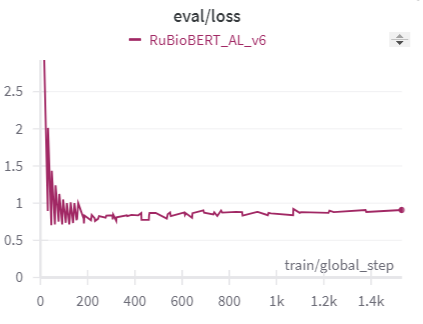    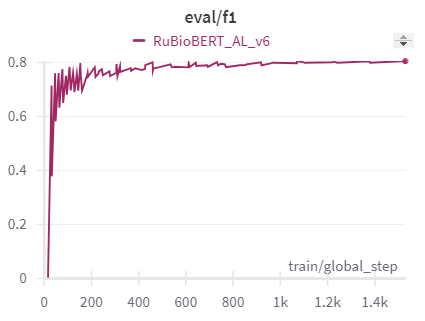